# 霍夫线变换

### 目标
在这一章当中， 
- 我们将了解霍夫变换的概念。
- 我们将看到如何使用它来检测图像中的线条。
- 我们将看到以下函数：**cv.HoughLines**()，**cv.HoughLinesP**()

### 理论

如果可以用数学形式表示形状，则霍夫变换是一种检测任何形状的流行技术。即使形状有些破损或变形，也可以检测出形状。我们将看到它如何作用于一条线。

一条线可以表示为$y = mx + c$或以参数形式表示为$\rho=xcosθ+ysinθ$，其中$\rho$是从原点到该线的垂直距离，而$\theta$是由该垂直线和水平轴形成的角度以逆时针方向测量（该方向随您如何表示坐标系而变化。此表示形式在OpenCV中使用）。查看下面的图片： 

![1](data/1.png)

因此，如果线在原点下方通过，则它将具有正的$\rho$且角度小于180。如果线在原点上方，则将角度取为小于180，而不是大于180的角度。$\rho$取负值。任何垂直线将具有0度，水平线将具有90度。
 
现在，让我们看一下霍夫变换如何处理线条。任何一条线都可以用$(ρ，θ)$这两个术语表示。因此，首先创建2D数组或累加器（以保存两个参数的值），并将其初始设置为$0$。让行表示$ρ$，列表示$θ$。阵列的大小取决于所需的精度。假设您希望角度的精度为1度，则需要180列。对于$ρ$，最大距离可能是图像的对角线长度。因此，以一个像素精度为准，行数可以是图像的对角线长度。

考虑一个`100x100`的图像，中间有一条水平线。取直线的第一点。您知道它的`(x，y)`值。现在在线性方程式中，将值$θ$= 0,1,2，..... 180放进去，然后检查得到$ρ$。对于每对$(ρ，θ)$，在累加器中对应的$(ρ，θ)$单元格将值增加1。所以现在在累加器中，单元格(50,90)= 1以及其他一些单元格。

现在，对行的第二个点。执行与上述相同的操作。递增$(\rho，\theta)$对应的单元格中的值。这次，单元格`(50,90)=2`。实际上，您正在对$(ρ，θ)$值进行投票。您对线路上的每个点都继续执行此过程。在每个点上，单元格(50,90)都会增加或投票，而其他单元格可能会或可能不会投票。这样一来，最后，单元格(50,90)的投票数将最高。因此，如果您在累加器中搜索最大票数，则将获得(50,90)值，该值表示该图像中的一条线与原点的距离为50，角度为90度。在下面的动画中很好地显示了该图片(图片提供：Amos Storkey)

![](data/houghlinesdemo.gif)

这就是霍夫变换对线条的工作方式。它很简单，也许您可​​以自己使用Numpy来实现它。下图显示了累加器。某些位置的亮点表示它们是图像中可能的线条的参数。（图片由维基百科提供）

![](data/houghlines2.jpg)

### OpenCV中的霍夫曼变换

上面说明的所有内容都封装在OpenCV函数**cv.HoughLines**()中。它只是返回一个：`math:(rho，theta)`值的数组。$ρ$以像素为单位，$θ$以弧度为单位。第一个参数，输入图像应该是二进制图像，因此在应用霍夫变换之前，请应用阈值或使用Canny边缘检测。第二和第三参数分别是$ρ$和$θ$精度。第四个参数是阈值，这意味着应该将其视为行的最低投票。请记住，票数取决于线上的点数。因此，它表示应检测到的最小线长。

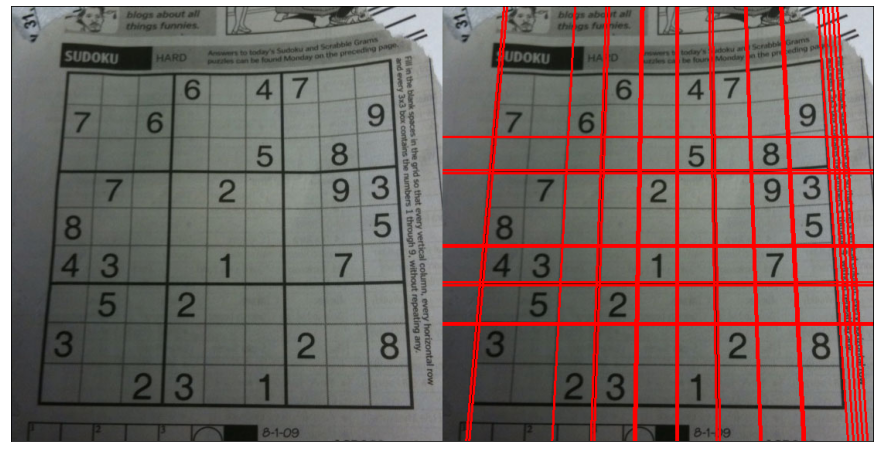

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

org = cv.imread('data/sudoku.png')
img = org.copy()

gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,50,150,apertureSize = 3)
lines = cv.HoughLines(edges,1,np.pi/180,200)

for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv.line(img,(x1,y1),(x2,y2),(0,0,255),2)

res = np.hstack((org, img))

plt.figure(figsize=(16,8))
plt.imshow(cv.cvtColor(res,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

#### 概率霍夫变换

在霍夫变换中，您可以看到，即使对于带有两个参数的行，也需要大量计算。概率霍夫变换是我们看到的霍夫变换的优化。它没有考虑所有要点。取而代之的是，它仅采用随机的点子集，足以进行线检测。只是我们必须降低阈值。参见下图，比较了霍夫空间中的霍夫变换和概率霍夫变换。（图片提供：Franck Bettinger的主页）

![](data/houghlines4.png)

OpenCV的实现基于Matas,J.和Galambos,C.和Kittler, J.V.使用渐进概率霍夫变换对行进行的稳健检测[145]。使用的函数是**cv.HoughLinesP**()。它有两个新的论点。
- **minLineLength** - 最小行长。小于此长度的线段将被拒绝。
- **maxLineGap** - 线段之间允许将它们视为一条线的最大间隙。

最好的是，它直接返回行的两个端点。在以前的情况下，您仅获得线的参数，并且必须找到所有点。在这里，一切都是直接而简单的。

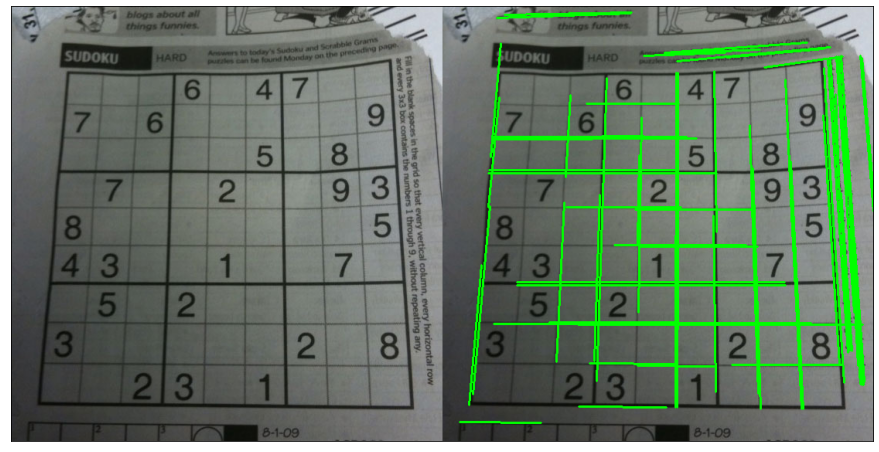

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

org = cv.imread('data/sudoku.png')
img = org.copy()

gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,50,150,apertureSize = 3)
lines = cv.HoughLinesP(edges,1,np.pi/180,100,minLineLength=100,maxLineGap=10)

for line in lines:
    x1,y1,x2,y2 = line[0]
    cv.line(img,(x1,y1),(x2,y2),(0,255,0),2)

res = np.hstack((org, img))

plt.figure(figsize=(16,8))
plt.imshow(cv.cvtColor(res,cv.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

### 附加资源

1. Hough Transform on Wikipedia：http://en.wikipedia.org/wiki/Hough_transform

### 练习